In [1]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

Let's use the same material definition as the existing pincell depletion example 

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Define overall material
material = openmc.Materials([uo2, helium, zircaloy, borated_water])

The geometry definition is going to be slightly different. Firstly, we want to bound the geometry in `z` assigning a pincell height. Secondly, we want to define a cell that contains a universe made of water and helium cells, separated by an interface, which we can initially set at $-59\ cm$ so that the initial condition of $k_{eff} \sim 1$ is satisfied. 

Filling the `msr` cell with a universe is the requirement to use the msr batchwise geometrical scheme as we will see later on.    

In [3]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr])

In [4]:
# Set material volume for depletion.
uo2.volume = pi * fuel_or.r**2 * height

In [5]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

Let's plot the pincell. We can notice the initial interface between the borated water and helium cells.

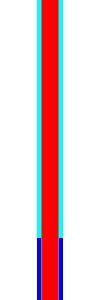

In [6]:
# Create plot
geometry.export_to_xml()
material.export_to_xml()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (5,200)
plot.pixels = (100,300)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
openmc.plot_inline(plot)

Let's now build and run a standard depletion calculation, increasing the thermal power to $100\ kW$. The results will be used as the reference to compare with the MSR capabilities:

In [7]:
#Create depletion "operator"
chain_file = 'chain_simple.xml'
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 100000  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59632
        

       35/1    1.00696    0.98669 +/- 0.00824
       36/1    0.97013    0.98605 +/- 0.00794
       37/1    1.03809    0.98798 +/- 0.00788
       38/1    0.94070    0.98629 +/- 0.00778
       39/1    0.98091    0.98610 +/- 0.00751
       40/1    1.02126    0.98727 +/- 0.00735
       41/1    0.94991    0.98607 +/- 0.00721
       42/1    1.00269    0.98659 +/- 0.00700
       43/1    0.99149    0.98674 +/- 0.00679
       44/1    0.94553    0.98553 +/- 0.00669
       45/1    0.96540    0.98495 +/- 0.00653
       46/1    1.04015    0.98648 +/- 0.00652
       47/1    1.01155    0.98716 +/- 0.00638
       48/1    0.89660    0.98478 +/- 0.00665
       49/1    0.95446    0.98400 +/- 0.00653
       50/1    1.06985    0.98615 +/- 0.00671
       51/1    0.97477    0.98587 +/- 0.00655
       52/1    0.98879    0.98594 +/- 0.00640
       53/1    0.96114    0.98536 +/- 0.00627
       54/1    0.96625    0.98493 +/- 0.00614
       55/1    1.02096    0.98573 +/- 0.00606
       56/1    1.01545    0.98637 

       87/1    1.02448    0.98815 +/- 0.00483
       88/1    1.02503    0.98863 +/- 0.00479
       89/1    1.03847    0.98926 +/- 0.00478
       90/1    1.01160    0.98954 +/- 0.00472
       91/1    0.94821    0.98903 +/- 0.00469
       92/1    0.99338    0.98908 +/- 0.00464
       93/1    0.98780    0.98906 +/- 0.00458
       94/1    0.92464    0.98830 +/- 0.00459
       95/1    0.92683    0.98757 +/- 0.00459
       96/1    0.95475    0.98719 +/- 0.00455
       97/1    1.08498    0.98832 +/- 0.00464
       98/1    1.09768    0.98956 +/- 0.00475
       99/1    0.96381    0.98927 +/- 0.00471
      100/1    1.03504    0.98978 +/- 0.00468
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.4822e+00 seconds
   Time in transport only          = 3.2546e+00 seconds
   Time in

        7/1    0.98002
        8/1    0.96370
        9/1    0.99900
       10/1    0.96703
       11/1    0.96500
       12/1    0.91204    0.93852 +/- 0.02648
       13/1    0.97054    0.94920 +/- 0.01865
       14/1    0.96771    0.95382 +/- 0.01397
       15/1    0.96546    0.95615 +/- 0.01107
       16/1    1.00173    0.96375 +/- 0.01181
       17/1    0.93087    0.95905 +/- 0.01103
       18/1    1.00467    0.96475 +/- 0.01112
       19/1    1.00083    0.96876 +/- 0.01060
       20/1    0.93290    0.96518 +/- 0.01013
       21/1    0.94134    0.96301 +/- 0.00942
       22/1    1.04423    0.96978 +/- 0.01094
       23/1    0.90481    0.96478 +/- 0.01124
       24/1    0.96055    0.96448 +/- 0.01041
       25/1    0.94192    0.96297 +/- 0.00981
       26/1    1.01977    0.96652 +/- 0.00984
       27/1    0.99783    0.96836 +/- 0.00942
       28/1    0.92710    0.96607 +/- 0.00917
       29/1    1.01654    0.96873 +/- 0.00907
       30/1    0.97036    0.96881 +/- 0.00861
       31/1

       60/1    0.96652    0.98893 +/- 0.00510
       61/1    0.98303    0.98882 +/- 0.00500
       62/1    0.99227    0.98888 +/- 0.00491
       63/1    1.01214    0.98932 +/- 0.00483
       64/1    0.93172    0.98826 +/- 0.00486
       65/1    0.96640    0.98786 +/- 0.00479
       66/1    0.93437    0.98690 +/- 0.00480
       67/1    0.93061    0.98592 +/- 0.00481
       68/1    1.03873    0.98683 +/- 0.00482
       69/1    1.05542    0.98799 +/- 0.00488
       70/1    0.97549    0.98778 +/- 0.00480
       71/1    0.98209    0.98769 +/- 0.00472
       72/1    0.93644    0.98686 +/- 0.00472
       73/1    1.02655    0.98749 +/- 0.00468
       74/1    0.91971    0.98643 +/- 0.00473
       75/1    0.93249    0.98560 +/- 0.00473
       76/1    0.96191    0.98524 +/- 0.00467
       77/1    0.98935    0.98530 +/- 0.00460
       78/1    1.00330    0.98557 +/- 0.00454
       79/1    0.96854    0.98532 +/- 0.00448
       80/1    0.97590    0.98519 +/- 0.00442
       81/1    0.94756    0.98466 

We can now analazie the depletion results:

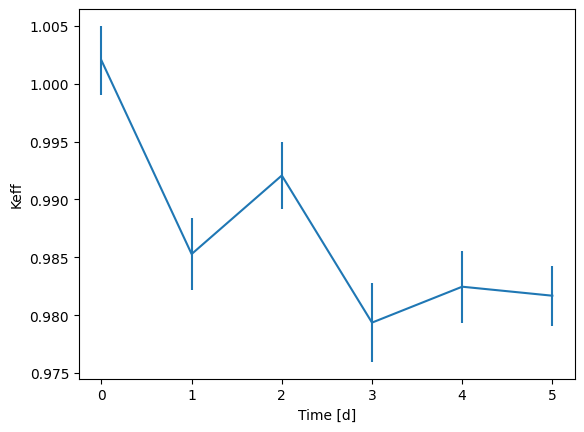

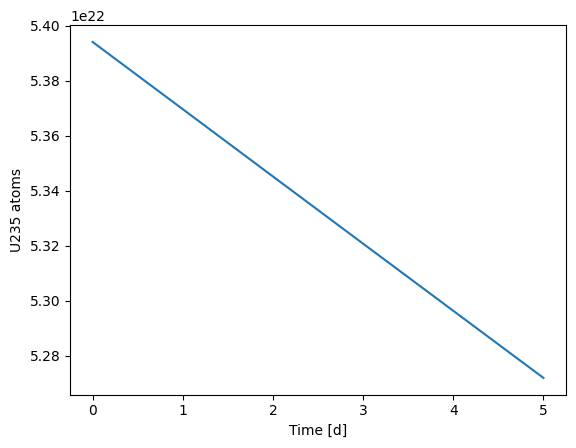

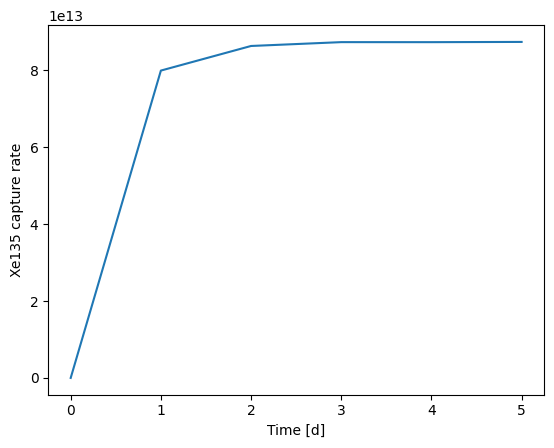

In [8]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_keff(time_units='d')

# Obtain U235 concentration as a function of time
_, n_U235 = results.get_atoms(uo2, 'U235')

# Obtain Xe135 capture reaction rate as a function of time
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

# Generate plots
fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

Let's now introduce the concept of `continuous removal rate` at which some nuclides/elements get removed from the materials, as an additional proportional term to the Bateman equations. This concept assumes first-order removal and homegeneous distributions of the fission products (or elements to removed) throughout the material.

$ \frac{dn_i(t)}{dt} = \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\overline{\sigma_j\phi} - n_i \overline{\sigma_i \phi}}_\textbf{R}  + \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\lambda_{i\rightarrow j} + \lambda_{j\rightarrow i}n_i}_\textbf{D} - \underbrace{\epsilon_i \lambda_i n_i}_\textbf{T}$

Where $ \epsilon_i \lambda_i n_i $ is the removal term, and:

- $\epsilon_i$ is the removal efficiency 

- $\lambda_i$ is the removal rate coefficient for the continuous removal of the nuclide $i$ in ($s^{-1}$)

Another way to characterize $\lambda_i$ is through the concept of cycle time:

$T_{cyc,i} = \frac{1}{\lambda_i}$, as the time needed to process the removal elements at a specific volumetric rate. 

For simplicity, we can combine $\epsilon_i$ and $\lambda_i$ in one single parameter, that we can call again $\lambda_i$. Thus, setting a removal rate coefficient of, for example, $1\ (s^{-1})$ at $100\ \%$ efficiency is the same as setting $10\ (s^{-1})$ at $10\ \%$.

A new depletion matrix can be built as: 

$\frac{d\vec{n}}{dt} = \underbrace{(\textbf{R+D-T})}_\textbf{A}\vec{n} $, 

where:

- $\textbf{R}$ is the reaction rate term
- $\textbf{D}$ is the decay rate term 
- $\textbf{T}$ is the removal rate or transfer term 

That can be solved in a similar fashion. 

Back to our case, let's set a removal rate of $0.1\ (s^{-1})$ for `Xenon` and re-run the the depletion model. 

To do it, we just need to instantiate a `openmc.deplete.msr.MsrContinuous` object and use the `set_removal_rate` function to set a removal rate to a list of elements (only `Xe` in this case) and the depletable material to remove it from. Lastly, we need to pass our instance to the integrator object.    

In [9]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Set removal rate from UO2 for Xe. Default units is [sec-1]
msr_c.set_removal_rate('UO2 fuel at 2.4% wt enrichment', ['Xe'], 0.1)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c,  timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1  

       34/1    1.00828    1.00941 +/- 0.00543
       35/1    1.00762    1.00934 +/- 0.00520
       36/1    0.95013    1.00706 +/- 0.00549
       37/1    1.03504    1.00810 +/- 0.00539
       38/1    1.02835    1.00882 +/- 0.00524
       39/1    0.97196    1.00755 +/- 0.00521
       40/1    1.03495    1.00846 +/- 0.00512
       41/1    1.05970    1.01012 +/- 0.00522
       42/1    1.01196    1.01018 +/- 0.00506
       43/1    1.00514    1.01002 +/- 0.00490
       44/1    0.98868    1.00939 +/- 0.00480
       45/1    1.02890    1.00995 +/- 0.00469
       46/1    0.93557    1.00789 +/- 0.00501
       47/1    0.99516    1.00754 +/- 0.00488
       48/1    1.00930    1.00759 +/- 0.00475
       49/1    0.97895    1.00685 +/- 0.00468
       50/1    1.02493    1.00731 +/- 0.00459
       51/1    1.02481    1.00773 +/- 0.00450
       52/1    1.05042    1.00875 +/- 0.00450
       53/1    0.94060    1.00716 +/- 0.00467
       54/1    0.97615    1.00646 +/- 0.00462
       55/1    0.92951    1.00475 

       86/1    1.09239    0.99744 +/- 0.00582
       87/1    0.99280    0.99738 +/- 0.00574
       88/1    0.99040    0.99729 +/- 0.00567
       89/1    1.05219    0.99798 +/- 0.00564
       90/1    1.00813    0.99811 +/- 0.00557
       91/1    0.91424    0.99707 +/- 0.00560
       92/1    1.02197    0.99738 +/- 0.00554
       93/1    0.95712    0.99689 +/- 0.00549
       94/1    1.03980    0.99740 +/- 0.00545
       95/1    0.99767    0.99740 +/- 0.00538
       96/1    1.00492    0.99749 +/- 0.00532
       97/1    0.90953    0.99648 +/- 0.00536
       98/1    0.96448    0.99612 +/- 0.00531
       99/1    1.00454    0.99621 +/- 0.00525
      100/1    1.00696    0.99633 +/- 0.00519
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 3.4698e+00 seconds
   Time in transport

        7/1    1.05055
        8/1    0.92375
        9/1    1.06982
       10/1    1.05582
       11/1    0.94377
       12/1    0.99614    0.96995 +/- 0.02618
       13/1    1.02428    0.98806 +/- 0.02359
       14/1    1.00347    0.99191 +/- 0.01712
       15/1    0.98311    0.99015 +/- 0.01338
       16/1    1.03128    0.99701 +/- 0.01290
       17/1    1.04627    1.00404 +/- 0.01297
       18/1    0.96674    0.99938 +/- 0.01216
       19/1    0.97210    0.99635 +/- 0.01115
       20/1    0.94016    0.99073 +/- 0.01145
       21/1    0.94160    0.98626 +/- 0.01128
       22/1    1.02741    0.98969 +/- 0.01085
       23/1    1.05155    0.99445 +/- 0.01106
       24/1    1.03693    0.99749 +/- 0.01068
       25/1    1.06625    1.00207 +/- 0.01094
       26/1    1.01419    1.00283 +/- 0.01027
       27/1    0.98122    1.00156 +/- 0.00973
       28/1    0.95121    0.99876 +/- 0.00959
       29/1    1.04007    1.00093 +/- 0.00933
       30/1    0.97153    0.99946 +/- 0.00897
       31/1

       57/1    0.96526    0.99184 +/- 0.00614
       58/1    0.91674    0.99027 +/- 0.00621
       59/1    0.98570    0.99018 +/- 0.00608
       60/1    1.06312    0.99164 +/- 0.00613
       61/1    1.03238    0.99244 +/- 0.00606
       62/1    1.01037    0.99278 +/- 0.00596
       63/1    0.95351    0.99204 +/- 0.00589
       64/1    0.97912    0.99180 +/- 0.00579
       65/1    0.91804    0.99046 +/- 0.00584
       66/1    1.03794    0.99131 +/- 0.00579
       67/1    1.00401    0.99153 +/- 0.00569
       68/1    1.04373    0.99243 +/- 0.00567
       69/1    1.02270    0.99295 +/- 0.00559
       70/1    0.98854    0.99287 +/- 0.00550
       71/1    0.94713    0.99212 +/- 0.00546
       72/1    0.93965    0.99128 +/- 0.00544
       73/1    0.85681    0.98914 +/- 0.00576
       74/1    1.02976    0.98978 +/- 0.00571
       75/1    1.02305    0.99029 +/- 0.00564
       76/1    1.01745    0.99070 +/- 0.00557
       77/1    0.98957    0.99068 +/- 0.00549
       78/1    1.03394    0.99132 

Let's open the results and plot them again:

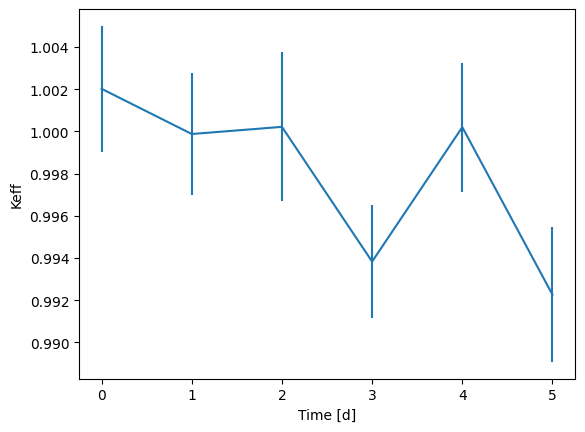

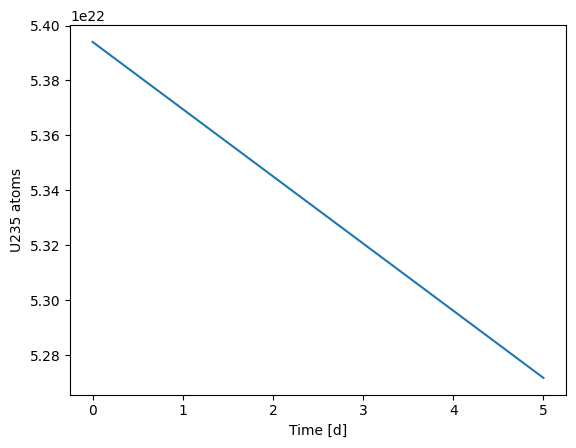

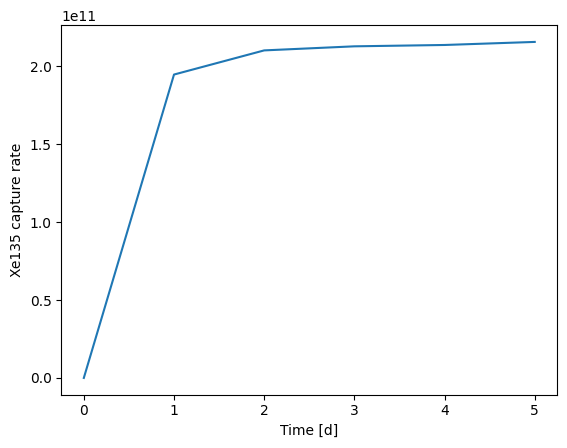

In [10]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can notice, `Xe135` capture rate has reduced indicating that the removal has worked, and consequently `keff` is kept almost constantly. 

Let's now show the capability of the `batchwise`control instead. We want to apply single actions in time to the system to fulfill some objectives, such as maintain a certain level of criticality. The current MSR implementation allows the user to define `geometry-based`or `material-based`actions. 

Back to our example, let's assume we want to maintain $k_{eff}$ close to its initial value $(\sim 1.00 )$ during the whole depletion time, by dynamically increasing the quantity of borated water that acts as moderator and compensates for the neutrons capture of the fission products build-up. 

The `msr` cell that was previously defined and filled with an universe containing borated water and helium gas, can translate up and down, increasing and decreasing the borated water cell volume, respectively. The `geometry-based` algorithm will run a `search_for_keff` at every depletion time-step to find a new interface geometrical coefficient that fulfills the target condition.  

Here we only need to instantiate  `openmc.deplete.msr.MsrBatchwiseGeom` object and set it up with the relevant arguments:

- $axis=\ 2$ : sets the cell translation on the z-axis
- $bracket=\ [-2,2]$: sets `search_for_keff` bracket to $\pm2\ cm$ from the initial or previous iteration geometrical value. 
- $bracket\ limit=\ [-100,100]$ : sets the limit to the iterative adaptive bracket method to the pincell lower and upper bound.  
- $tol=\ 0.01$ : sets `search_for_keff` tolerance 
- $target=\ 1.145$ : sets `search_for_keff` target 


In [14]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr batchwise geometrical instance
msr_g = openmc.deplete.msr.MsrBatchwiseGeom(op, model, cell_id_or_name = 'MSR',
                axis=2, bracket=[-2,2], bracket_limit=[-100,100], tol=0.01, target=1.00)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_batchwise=msr_g,  timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.59632
        2/1    0.68857
        3/1    0.83620
        4/1    0.87469
        5/1    0.87808
        6/1    0.95547
        7/1    0.99002
        8/1    0.95135
        9/1    1.06003
 

Iteration: 3; Guess of 3.88e+00 produced a keff of 1.00037 +/- 0.00271
Iteration: 4; Guess of 3.81e+00 produced a keff of 0.99785 +/- 0.00319
Iteration: 5; Guess of 3.87e+00 produced a keff of 1.00177 +/- 0.00302
Iteration: 6; Guess of 3.84e+00 produced a keff of 1.00021 +/- 0.00278
Iteration: 7; Guess of 3.84e+00 produced a keff of 1.00169 +/- 0.00287
Iteration: 8; Guess of 3.83e+00 produced a keff of 0.99981 +/- 0.00347
Iteration: 9; Guess of 3.83e+00 produced a keff of 1.00861 +/- 0.00302
UPDATE: old value: 3.22 cm --> new value: 3.83 cm
[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=100000
Iteration: 1; Guess of 1.83e+00 produced a keff of 0.99193 +/- 0.00300
Iteration: 2; Guess of 5.83e+00 produced a keff of 1.01531 +/- 0.00285
Iteration: 3; Guess of 3.21e+00 produced a keff of 1.00178 +/- 0.00292
Iteration: 4; Guess of 2.96e+00 produced a keff of 1.00318 +/- 0.00299
Iteration: 5; Guess of 2.39e+00 produced a keff of 0.99744 +/- 0.00288
Iteration: 6; Guess of 2.64e+00 produce

By looking at the output, we  can notice that when `search_for_keff` bracket goes off target, the method iteratively adapts it. 

Again, let's analyse the results:

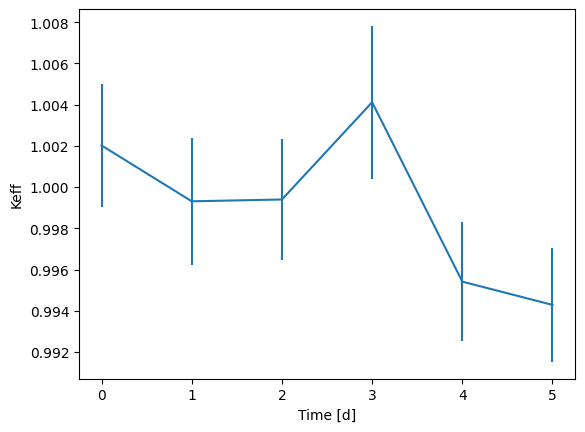

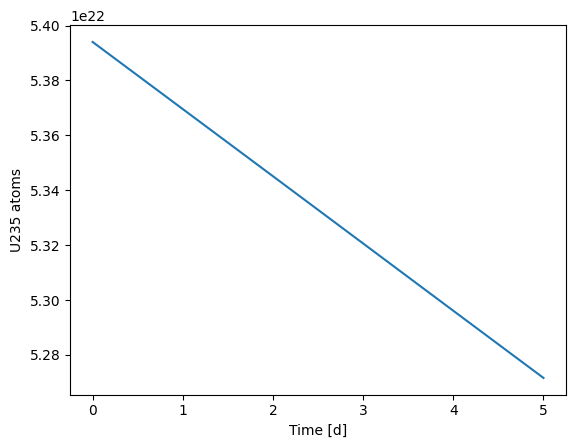

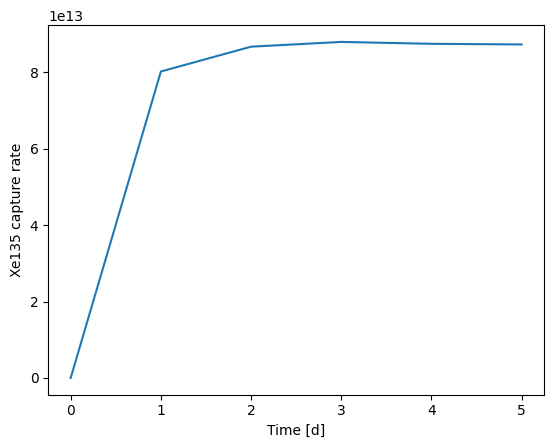

In [15]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can see, $k_{eff} \sim 1$ is kept (within statistical uncertainity), even though `Xe135`(main absorber) doesn't get removed (we didn't define any removal rates in this case). This is achieved through the raise of the water level, as we can notice by plotting the results stored in `msr_results.h5`:

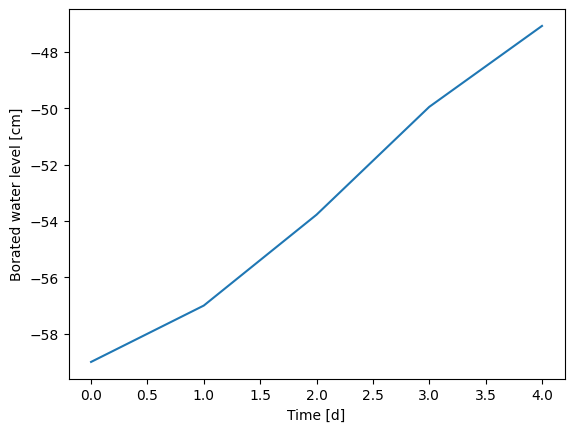

In [16]:
# To open the h5 file we need some imports
import h5py
import numpy as np
h = h5py.File('msr_results.h5','r')
vals = [] 
for key in h.keys():
    vals.append(np.array(h.get(key)))
fig, ax = plt.subplots()
# Offset the values by 59cm, our initial water level height
vals = np.cumsum(vals) - 59
ax.plot(time[:-1], vals)
ax.set_xlabel("Time [d]")
ax.set_ylabel("Borated water level [cm]")
plt.show()